In [1]:
import os
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

raw_dir = Path("data/raw")
files = os.listdir(raw_dir)
csv_files = [raw_dir / f for f in files if f.endswith(".csv")]
if not csv_files:
    print("ERROR: No raw CSV files found")
    exit(1)

In [2]:

print(csv_files)

latest_stamp = ""
for f in csv_files:
    # expecting format "sales_YYYYMMDD_HHmm.csv"
    ts = f.name.split("_")[1].replace(".csv","") # --> YYYYMMDD_HHmm
    if ts > latest_stamp: # good old string comparison
        latest_stamp = ts
        latest_file = f

[PosixPath('data/raw/sales_20251203_1225.csv'), PosixPath('data/raw/sales_data.csv'), PosixPath('data/raw/sales_20251204_0822.csv'), PosixPath('data/raw/sales_20251203_1222.csv')]


In [3]:
print(f"Loading: {latest_file}")


Loading: data/raw/sales_data.csv


In [4]:

# Load data
df = pd.read_csv(latest_file)


In [5]:
df.head()

,timestamp,model,sales
0,2025-04-25T09:06:57Z,rtx3060,13
1,2025-04-25T09:06:57Z,rtx3070,17
2,2025-04-25T09:06:57Z,rtx3080,17
3,2025-04-25T09:06:57Z,rtx3090,14
4,2025-04-25T09:06:57Z,rx6700,16


In [6]:
df.dtypes

timestamp    object
model        object
sales         int64
dtype: object

In [7]:
# missing values - nope. But will be added to preprocessing.
df.isna().sum()

timestamp    0
model        0
sales        0
dtype: int64

In [8]:
df.model.unique()
# models correct - but any invalid model will be removed from downstream processes

array(['rtx3060', 'rtx3070', 'rtx3080', 'rtx3090', 'rx6700'], dtype=object)

<Axes: >

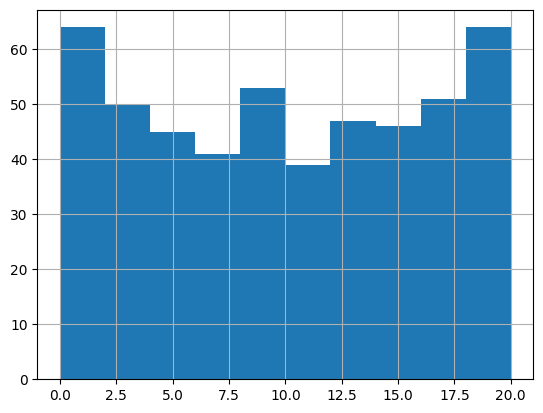

In [ ]:
df["sales"].hist()
# remove negative sales

<Axes: xlabel='timestamp'>

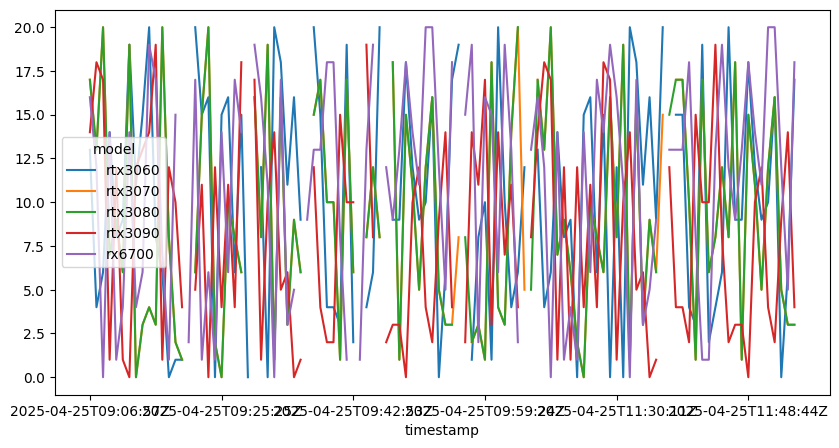

In [10]:
df_pivot = df.pivot(index="timestamp", columns="model", values="sales")
df_pivot.plot(kind="line", figsize=(10,5))

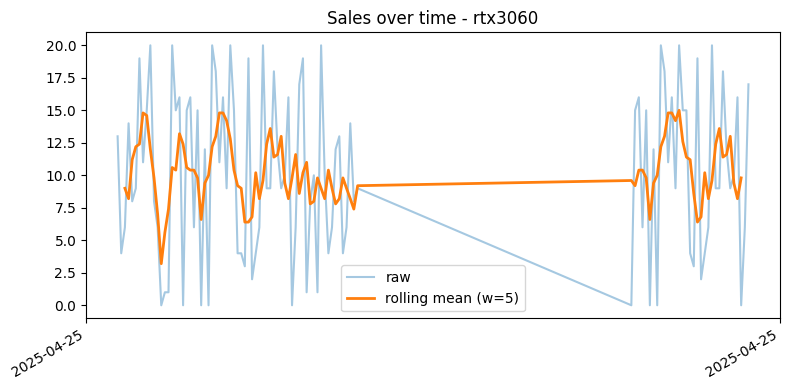

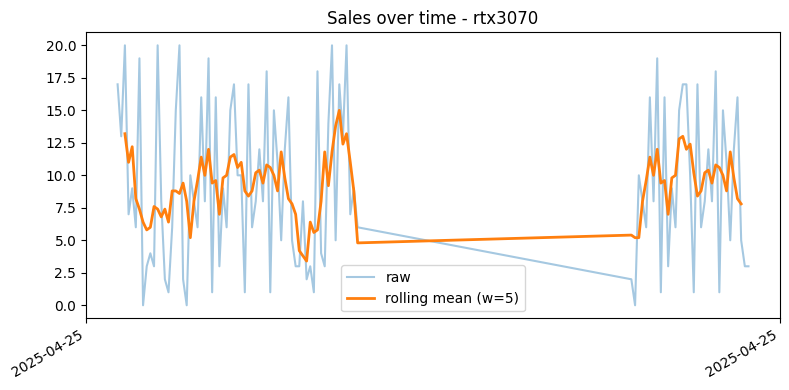

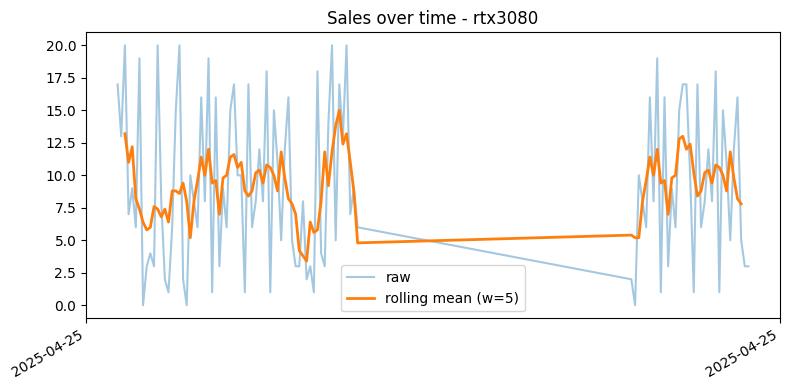

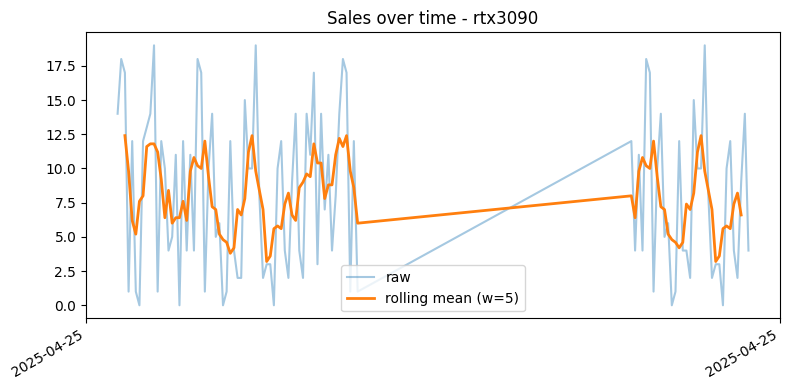

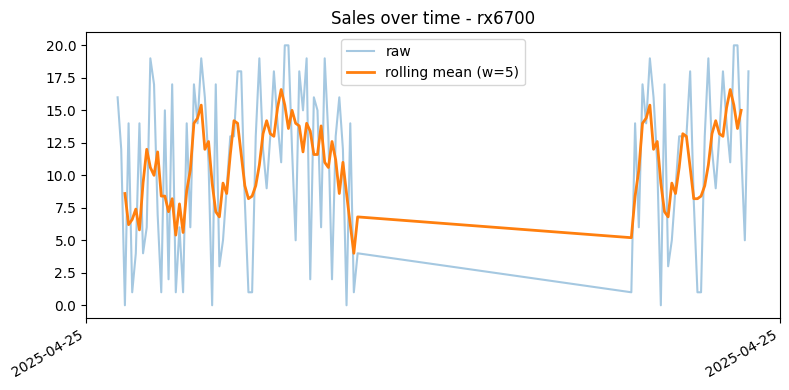

In [22]:
import matplotlib.dates as mdates
df["timestamp"] = pd.to_datetime(df["timestamp"])

for model, sub in df.groupby("model"):
    sub = sub.sort_values("timestamp")
    sub["sales_smooth"] = sub["sales"].rolling(window=5, center=True).mean()

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(sub["timestamp"], sub["sales"], alpha=0.4, label="raw")
    ax.plot(sub["timestamp"], sub["sales_smooth"], linewidth=2, label="rolling mean (w=5)")

    # Format x-axis to show only the date (day resolution)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())  # one tick per day
    fig.autofmt_xdate()  # rotate labels so they don't overlap

    ax.set_title(f"Sales over time - {model}")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [28]:
# possible features

before = len(df)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors="coerce")
invalid = df[pd.to_datetime(df["timestamp"], errors="coerce").isna()]["timestamp"]
df = df.dropna(subset=["timestamp"]).reset_index(drop=True)
after = len(df)
# log 
removed = before -  after 
invalid

df['hour'] = df['timestamp'].dt.hour.astype(int)
df['day_of_week'] = df['timestamp'].dt.dayofweek.astype(int)
df['day_of_month'] = df['timestamp'].dt.day.astype(int)
df['month'] = df['timestamp'].dt.month.astype(int)
df.drop(columns=["timestamp"])

,model,sales,hour,day_of_week,day_of_month,month
0,rtx3060,13,9,4,25,4
1,rtx3070,17,9,4,25,4
2,rtx3080,17,9,4,25,4
3,rtx3090,14,9,4,25,4
4,rx6700,16,9,4,25,4
...,...,...,...,...,...,...
495,rtx3060,17,11,4,25,4
496,rtx3070,3,11,4,25,4
497,rtx3080,3,11,4,25,4
498,rtx3090,4,11,4,25,4


hour


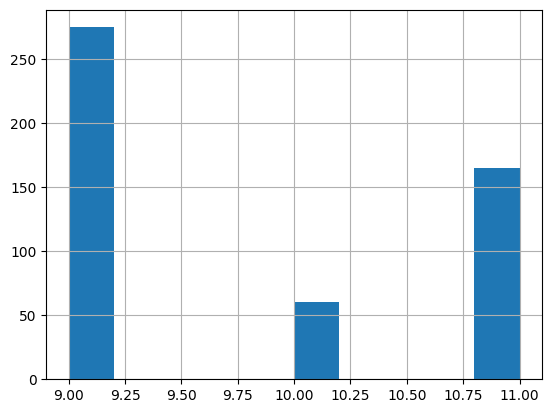

day_of_week


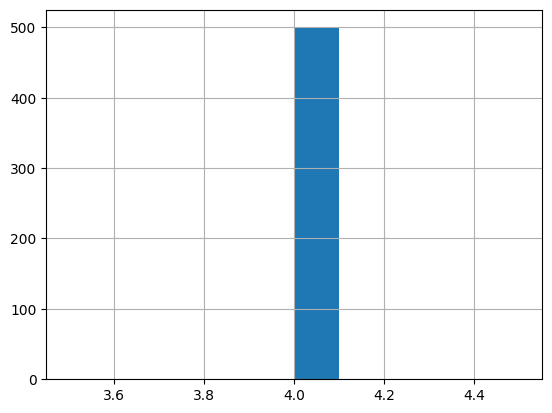

day_of_month


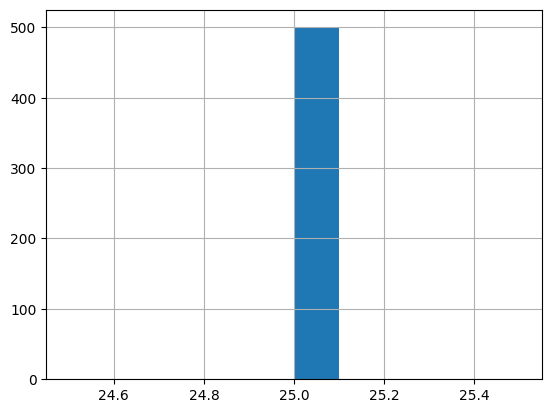

month


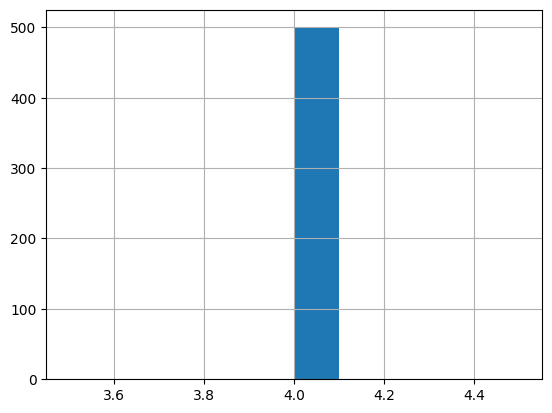

In [35]:
for feature in ["hour", "day_of_week", "day_of_month", "month"]: 
    print(feature)
    df[feature].hist()
    plt.show()

In [29]:
def plot_feature(df, feature):
    for model, sub in df.groupby("model"):
        grouped = (
            sub.groupby(feature)["sales"]
               .mean()
               .sort_index()
        )

        plt.figure(figsize=(8, 4))
        plt.plot(grouped.index, grouped.values, marker="o")
        plt.title(f"{model} – sales by {feature}")
        plt.xlabel(feature)
        plt.ylabel("sales")
        plt.tight_layout()
        plt.show()

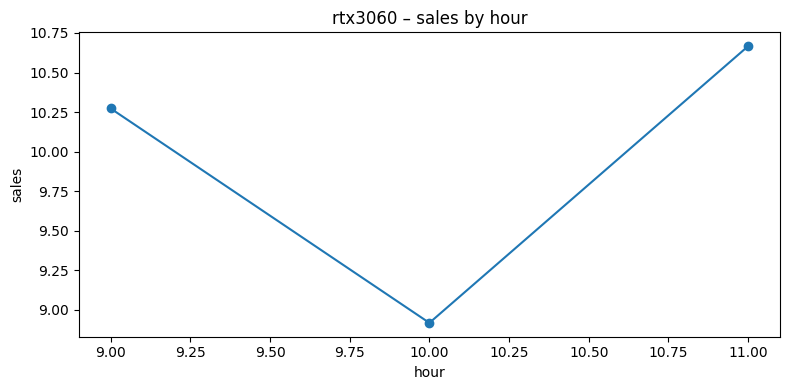

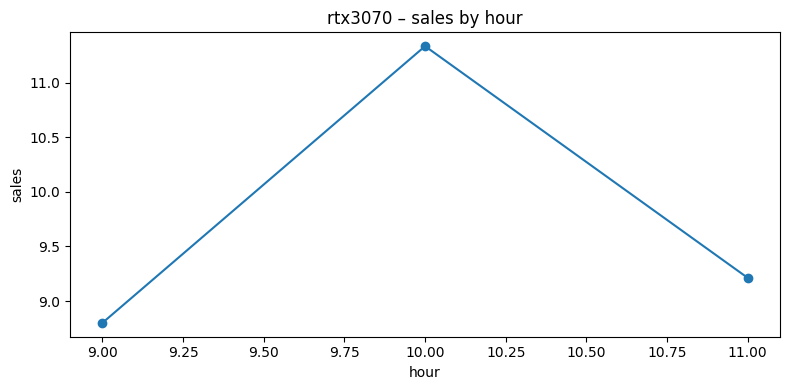

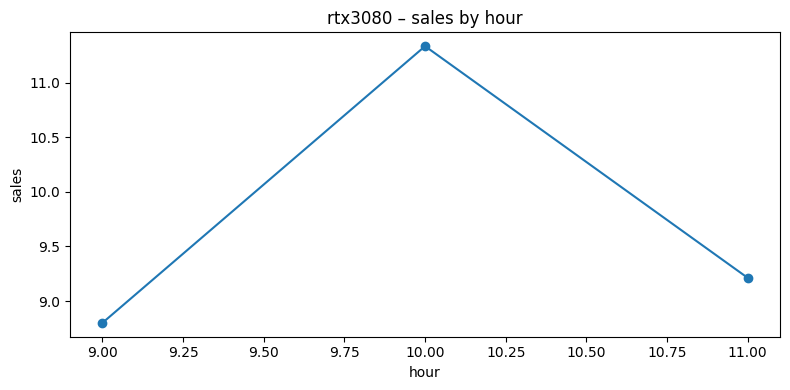

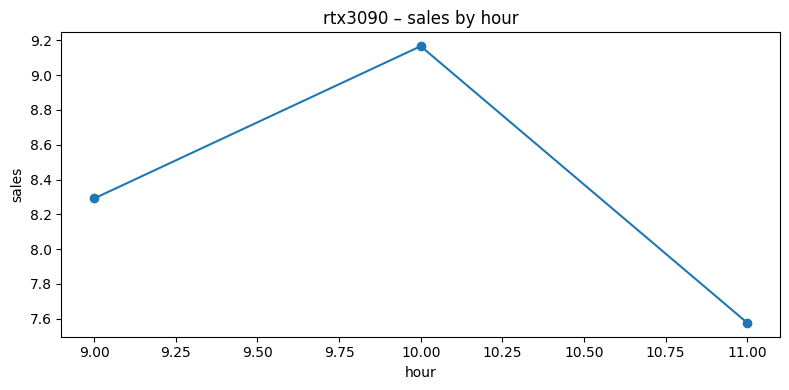

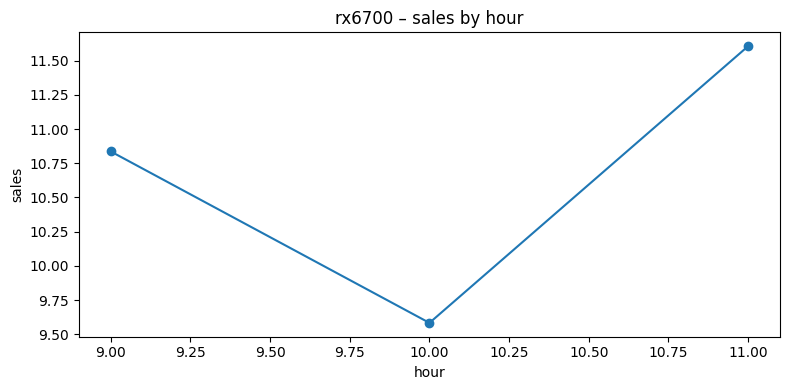

In [36]:
plot_feature(df, "hour")

In [11]:
df.head()

,timestamp,model,sales,hour,day_of_week,day_of_month,month
0,2025-04-25 09:06:57+00:00,rtx3060,13,9,4,25,4
1,2025-04-25 09:06:57+00:00,rtx3070,17,9,4,25,4
2,2025-04-25 09:06:57+00:00,rtx3080,17,9,4,25,4
3,2025-04-25 09:06:57+00:00,rtx3090,14,9,4,25,4
4,2025-04-25 09:06:57+00:00,rx6700,16,9,4,25,4


In [12]:
le = LabelEncoder()
df['model_encoded'] = le.fit_transform(df['model']).astype(int)

In [13]:
df.head()

,timestamp,model,sales,hour,day_of_week,day_of_month,month,model_encoded
0,2025-04-25 09:06:57+00:00,rtx3060,13,9,4,25,4,0
1,2025-04-25 09:06:57+00:00,rtx3070,17,9,4,25,4,1
2,2025-04-25 09:06:57+00:00,rtx3080,17,9,4,25,4,2
3,2025-04-25 09:06:57+00:00,rtx3090,14,9,4,25,4,3
4,2025-04-25 09:06:57+00:00,rx6700,16,9,4,25,4,4


In [14]:
df = df.drop(columns=["model", "timestamp"])
df.head()

,sales,hour,day_of_week,day_of_month,month,model_encoded
0,13,9,4,25,4,0
1,17,9,4,25,4,1
2,17,9,4,25,4,2
3,14,9,4,25,4,3
4,16,9,4,25,4,4


In [15]:
df = df[["model_encoded", "hour", "day_of_week", "day_of_month", "month", "sales"]]

In [16]:
df.head()

,model_encoded,hour,day_of_week,day_of_month,month,sales
0,0,9,4,25,4,13
1,1,9,4,25,4,17
2,2,9,4,25,4,17
3,3,9,4,25,4,14
4,4,9,4,25,4,16


In [18]:
files = os.listdir(raw_dir)
csv_files = [raw_dir / f for f in files if f.endswith(".csv")]
if not csv_files:
    print("ERROR: No raw CSV files found")
    exit(1)

In [21]:
ts_files = []
for f in csv_files:
    print(f)
    # expecting format "sales_YYYYMMDD_HHmm.csv"
    parts = f.name.split("_")
    print(parts)
    if len(parts) == 3 and parts[0] == "sales":  # now also checking for these formats
        ts_parts = "_".join(parts[1:])
        print(ts_parts)
        ts = ts_parts.replace(".csv", "")
        if len(ts) == 13 and "_" in ts:
            ts_files.append(f)



data/raw/sales_20251203_0939.csv
['sales', '20251203', '0939.csv']
20251203_0939.csv
data/raw/sales_data.csv
['sales', 'data.csv']
data/raw/sales_20251203_0937.csv
['sales', '20251203', '0937.csv']
20251203_0937.csv
data/raw/sales_20251203_0934.csv
['sales', '20251203', '0934.csv']
20251203_0934.csv
data/raw/sales_20251203_0947.csv
['sales', '20251203', '0947.csv']
20251203_0947.csv
data/raw/sales_20251203_0938.csv
['sales', '20251203', '0938.csv']
20251203_0938.csv
data/raw/sales_20251203_0933.csv
['sales', '20251203', '0933.csv']
20251203_0933.csv
data/raw/sales_20251203_0935.csv
['sales', '20251203', '0935.csv']
20251203_0935.csv
data/raw/sales_20251203_0926.csv
['sales', '20251203', '0926.csv']
20251203_0926.csv
data/raw/sales_20251203_1035.csv
['sales', '20251203', '1035.csv']
20251203_1035.csv


In [23]:
if not ts_files:
    print("  ERROR: No CSV files matching expected pattern found!")
    exit(1)

latest_ts = ""
latest_file = None
for f in ts_files:
    ts = f.name.split("_")[1].replace(".csv", "")
    if ts > latest_ts:
        latest_ts = ts
        latest_file = f
print(latest_file)

data/raw/sales_20251203_0939.csv
